## Introduction

This notebook provides a SCA (statistical coupling analysis) of the eukaryotic protein kinase superfamily.  The goal is to examine the association between the evolutionary conservation, the kinase sector (co-evolution), and: (1) the kinase "spines", conserved structural motifs originally described in the context of PKA (2) a  mutational scan of solvent exposed acidic residues (Asp/Glu) on the S. cerevisaie kinase KSS1 (3) a mutational scan of all positions in H. sapiens kinase ERK2 (a KSS1 homolog) (4) known regulatory mutations spanning a diversity of kinases across the kinome (drawn from the literature) and (4) a well-studied allosteric inhibitor binding site on Abl Kinase. 

We see that the kinase "spines" are largely encapsulated in the sector, and observe a statistically significant association for 2-4 with both the sector, and conserved positions (in the absence of considering co-evolution). The allosteric inhibitor binding site on Abl appears sector connected. These results suggest that the sector provides a latent, conserved allosteric architecture embedded within the protein kinase, and that conserved sites on the protein surface may be hotspots for the engineering and evolution of new allosteric regulation.

### The Inputs, and some specifics of the analysis:

1. All analysis is performed with SCA6, as described in Rivoire et al. (2016) "Evolution Based Functional Decomposition of Proteins", PLoS Comp Biol. 

2. We use two alignments: 
    - CMGC_KinaseMSA.fasta - This alignment is focused on the CMGC kinase family, and was collected by searching kinbase (http://kinase.com/kinbase/).  Sequences were filtered for a length of 250-350 amino acid, and aligned by Promals3D, including the PDBS: 2B9H, 1BI8, 1Q97, 2ERK, 2F49, 2F9G, 2IW8, 2R7I, as a reference structures. (starting alignment: 635 sequences, 1281 positions)
    
    - masterAln.an - A pre-constructed and manually curated kinome-wide alignment distributed from the kinase sequence database (Shokat lab, http://sequoia.ucsf.edu/ksd/). This alignment was constructed by HMM profiling of kinases, subfamily sequence alignment, and finally alignment of all the families to each other. I downloaded the excel spreadsheet of the master alignment (masterAln.xls), exported to text (masterAln.txt), and converted to fasta format (using the script parseAln.py). At this point,subfamily identifiers (based on sequence analysis and assigned by the Shokat lab) were added to the fasta headers. GI numbers were extracted from the sequence headers and used toannotate the alignment with phylogeny information. (starting alignment: 7128 sequences, 3238 positions)

3. In several places in this notebook, we use the yeast kinase Pho85 2PK9 structure as a common reference for mapping the sector. This structure is also used in the initial step of processing (and truncating) the alignment for SCA. This structure was selected as follows:
    - We collected all available yeast kinase structures (as of Nov. 2014, 22 total)
    - For each kinase class (CKA1: 5 structures, FUS3: 7, PHO85: 4, SKY1: 6), we aligned the structures and took the structure with the smallest RMSD to all others
    - For these four structures (1q97, 2b9j, 2pk9, 4fi1), we repeated the alignment and RMSD calculation step: 2PK9 is chosen as the most representative.
    

**Commands for running SCA** (for more details on how to use SCA, please see: http://reynoldsk.github.io/pySCA/). The input files for the analysis are the alignments described above and a reference structure (2PK9.pdb, chain A). For both alignments we consider the top 4 independent components (ICs), and four different significance cutoffs (0.95, 0.96, 0.97, 0.98). The script runAnalysis.sh will execute these commands, resulting in eight logfiles (masterAln\_\*\_2PK9t.log and CMGC\_\*\_2PK9.log, where \* = cutoff) and eight corresponding pickle databases (\*.db files) - all stored in the Outputs/ directory.  The pickle databases contain the results of the calculations in a compressed form. The commands for each alignment at *one* significance cutoff (0.95) look like:

    >> ./scaProcessMSA.py Inputs/CMGC_KinaseMSA.fasta -s 2PK9 -c A --output CMGC_095_2PK9 > Outputs/CMGC_095_2PK9.log
    >> ./scaCore.py Outputs/CMGC_095_2PK9.db >> Outputs/CMGC_095_2PK9.log
    >> ./scaSectorID.py -p 0.95 -k 4 Outputs/CMGC_095_2PK9.db >> Outputs/CMGC_095_2PK9.log

    >> ./scaProcessMSA.py Inputs/masterAln.an -s 2PK9 -c A -t --output masterAln_095_2PK9t >> Outputs/masterAln_095_2PK9t.log
    >> ./scaCore.py Outputs/masterAln_095_2PK9t.db >> Outputs/masterAln_095_2PK9t.log
    >> ./scaSectorID.py Outputs/masterAln_095_2PK9t.db -p 0.95 >> Outputs/masterAln_095_2PK9t.log

**This version of the jupyter notebook accompanies: **
Pincus D, Pandey J.P., Creixell P., Resnekov O., Reynolds K.A. *Evolution and Engineering of Allosteric Regulation in Protein Kinases. *

Apr. 2018, v6.  K. Reynolds. Revising to include comments, references to manuscript.

## Preliminaries: Loading the SCA results and a comparison of the two alignments

In [105]:
#import the necessary modules
%matplotlib inline
from __future__ import division
import os
import time
import matplotlib.pyplot as plt
import matplotlib
import scipy.cluster.hierarchy as sch
import numpy as np
import copy
import math
import scaTools as sca
from scipy.stats import t
from scipy.stats import scoreatpercentile 
from scipy.stats import fisher_exact
import cPickle as pickle

In [106]:
#Defining a few useful classes and functions.
class SCAResults:
    def __init__(self):
        self.name = ''
        self.seq = 0
        self.sca = 0
        self.sect = 0

# Compute the statistical significance of association between two different residue groups. 
# (e.g. sector and experimental mutations).
# Uses one-sided Fisher exact test, a method appropriate for small sample sizes 
# binned into discrete categories. Note that toggling the argument "v" allows this function
# to be more or less verbose.
def compStatAssoc(sec, mut, allRes, v = 1, cat1 = 'sector', cat2 = 'mutational effect'):
    nonMut = allRes - mut
    nonSec = allRes - sec
    mutsec = sec.intersection(mut)
    mutnonsec = nonSec.intersection(mut)
    nonmutsec = sec.intersection(nonMut)
    nonmutnonsec = nonSec.intersection(nonMut)
    Nmutsec, Nmutnonsec =  len(mutsec), len(mutnonsec)
    Nnonmutsec, Nnonmutnonsec = len(nonmutsec), len(nonmutnonsec)
    cont_table = [[Nmutsec,Nnonmutsec],[Nmutnonsec, Nnonmutnonsec]]
    odds_ratio, pval = fisher_exact(cont_table, 'greater')
    if (v):
        #print ('Contacting pos:')
        #print '+'.join(mutsec)
        print ('There are %i positions which are both in %s and %s' \
               % (Nmutsec, cat1, cat2))
        print ('There are %i positions which are in %s but not %s' \
               % (Nnonmutsec, cat1, cat2))
        print ('There are %i which are in %s but not %s' \
               % (Nmutnonsec, cat2, cat1))
        print ('There are %i positions which are neither %s or %s' \
               % (Nnonmutnonsec, cat1, cat2))
    
    return pval, cont_table

# Construct an alignment-to-structure mapping (ATS)
# This is used to convert between alignment numbering schemes and structure positions in a
# given PDB
def buildATS(alignment, indexFile, refposFileArg = ''):
    f = open(indexFile, 'r')
    protLines = f.readlines()
    ATSmap = {}
    seqIx = {}
    for k in protLines:
        prot,index =k.split()
        if refposFileArg == '':
            refposFile = prot+'.pos'
        else: 
            refposFile = refposFileArg
        refpos = 'Refpos/'+refposFile
        outputfile= 'Outputs/ATS_'+prot
        cmd1='./scaMakeATS.py Inputs/'+alignment+ ' -i '+index+' -o '+refpos+' --output '+outputfile+' > '+outputfile+'.log'
        print cmd1
        os.system(cmd1)
        dbtmp= pickle.load(open(outputfile+'.db', 'rb'))
        ATSmap[prot] = (dbtmp['sequence']['ats'])
        seqIx[prot] = (int(index))
    if len(seqIx) == 1:
        return ATSmap[ATSmap.keys()[0]],seqIx[ATSmap.keys()[0]]
    else:
        return ATSmap,seqIx

#Identify all residues contacting another group of residues
#Used to define sector contacting positions.
def findContacts(distMat,distATS,resGroup):
    conn = []
    for i,pos in enumerate(resGroup):
        if pos in distATS:
            contacts = np.where(distMat[distATS.index(pos),:] < 4 )[0]
            contactPos = [distATS[k] for k in contacts]
            conn = conn + contactPos
    return set(conn)

# Read in a distance matrix (assumes csv format) - used for finding structural contacts
def readDistMat(matrixFile):
    f=open(matrixFile, 'r')
    dist = f.readlines()
    distMat = np.zeros([len(dist),len(dist)])
    for i,line in enumerate(dist):
        distMat[i,:] = line.split(',')
    return distMat

We begin by loading the results of the SCA calculation (for both the kinome-wide and CMGC-kinase specific alignments, at all four significance cutoffs). The data are stored as pickle databases; once they are loaded we can access the calculation results through a SCAResults object containing three python dictionaries: Dseq, Dsca and Dsect. 

**Note:** To ensure reproducibility of the exact results in our paper, and to minimize the overhead needed to reproduce our calculations, we supply all of the db files used in our manuscript in the directory Outputs_1703. If you wish to instead use new Outputs (e.g. if you re-calculate everything from scratch, or with changes to the input variables), you'll need to comment out the line referring to Outputs_1703, and uncomment the line: 'pickle.load(open('Outputs/'+name+'.db', 'rb'))'. Note that re-running SCA can sometimes lead to small variations in outcome - in particular, scaProcessMSA subsamples the full sequence alignment randomly (for computational efficiency) and so some run-to-run variability may apear. 

In [107]:
alnLabels = ['Full alignment', 'CMGC alignment']
IC_CDFcutoff = ['095', '096', '097', '098']
dbNames = []
dbNames.append(['masterAln_'+cut+'_2PK9t' for cut in IC_CDFcutoff])
dbNames.append(['CMGC_'+cut+'_2PK9' for cut in IC_CDFcutoff])
allResults = {}

for k,label in enumerate(alnLabels):
    alnRes = []
    for name in dbNames[k]:
        db = pickle.load(open('Outputs_1703/'+name+'.db', 'rb'))
        #db = pickle.load(open('Outputs/'+name+'.db', 'rb'))
        s = SCAResults()
        s.name = name
        s.Dseq = db['sequence']
        s.Dsca = db['sca']
        s.Dsect = db['sector']
        alnRes.append(s)
    allResults[label] = alnRes

** To evaluate and compare the sequence diversity within the two alignments, we plot: **
 1. A matrix of sequence similarities between all pairs of amino acid sequences
 2. A histogram of pairwise sequence identities (Fig.4A-B in Pincus et al)

Full alignment:
After processing, the alignment size is 976 sequences and 199 positions
With sequence weights, there are 380 effective sequences
CMGC alignment:
After processing, the alignment size is 615 sequences and 272 positions
With sequence weights, there are 464 effective sequences


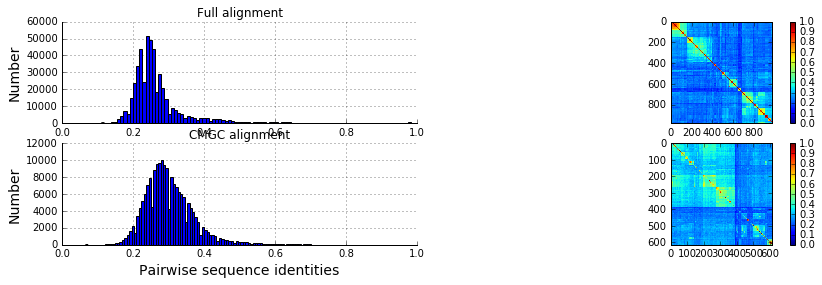

In [108]:
#some basic alignment stats
for k in alnLabels:
    print k+":"
    print("After processing, the alignment size is %i sequences and %i positions" % \
          (allResults[k][0].Dseq['Nseq'], allResults[k][0].Dseq['Npos']))
    print("With sequence weights, there are %i effective sequences" % (allResults[k][0].Dseq['effseqs']))

#plot distribution of sequence identities
plt.rcParams['figure.figsize'] = 14, 10
for p,k in enumerate(alnLabels):
    listS = [allResults[k][0].Dsca['simMat'][i,j] for i in range(allResults[k][0].Dsca['simMat'].shape[0]) \
             for j in range(i+1, allResults[k][0].Dsca['simMat'].shape[1])]
    Z = sch.linkage(allResults[k][0].Dsca['simMat'],method = 'complete', metric = 'cityblock')
    R = sch.dendrogram(Z,no_plot = True)
    ind = map(int, R['ivl'])
    plt.rcParams['figure.figsize'] = 14, 4 
    axs = plt.subplot(2,2,p*2+1)
    plt.hist(listS, math.ceil((allResults[k][0].Dseq['Npos']+1)/2)) 
    plt.xlabel('Pairwise sequence identities', fontsize=14)
    plt.xlim([0,1])
    plt.ylabel('Number', fontsize=14)
    plt.title(k); plt.grid()
    axs.set_axisbelow(True)
    axs.spines['top'].set_visible(False); axs.spines['right'].set_visible(False)
    axs.get_xaxis().tick_bottom(); axs.get_yaxis().tick_left()
    plt.subplot(2,2,p*2+2)
    plt.imshow(allResults[k][0].Dsca['simMat'][np.ix_(ind,ind)], vmin=0, vmax=1); 
    plt.colorbar();
    #plt.savefig('Plots/SeqSimAln.pdf')

So, the two alignments look diverse and well-behaved - each shows a unimodal distribution of sequence identities, with a tail of of higher identity sequences corresponding to small clusters or clades. As expected, the full kinase alignment shows stronger family structure (evident in the pairwise sequence identity matrix), and the CMGC alignment contains higher identity sequences (with a mean pairwise identity near 30%, for the full alignment this is closer to 25%).

## I. Sector Definitions

For both alignments, we follow an identical procedure for defining the sector. A full description of the SCA calculations is provided in Rivoire O, Reynolds KA, Ranganathan R (2016) Evolution-Based Functional Decomposition of Proteins. PLoS Comput Biol 12(6): e1004817. Briefly, we compute a conservation-weighted covariance matrix between all pairs of amino acid positions. This matrix provides a statistical description of the "evolutionary coupling" between all pairs of amino acid positions. We then analyze this matrix by conducting principle components analysis (PCA), and rotating the top eigenmodes using independent components analysis (ICA). The top independent components are used to define sectors. 

For both kinase alignments, we define a single sector that includes all positions contributing to the top 4 independent components (ICs).  The group of positions contributing to each IC groups is defined by fitting an empirical statistical distribution to the ICs and choosing positions above a defined cutoff (default, > 95% of the CDF). These positions were determined during the course of running the SCA analysis scripts (in particular, scaSectorID.py). Below, we show the conservation-weighted covariance matrix for the *subset* of amino acid positions that contribute to the top four ICS. The positions are grouped according to the ICs to which they contribute - this allows us to examine the pattern of co-evolution both within and between ICs. From the visual examination of this matrix, we see some degree of co-evolution between all 4 ICs, and thus decide to group all positions into a single sector. 

Below, we consider the matrices and sector positions for the default IC CDF cutoff of 0.95. Later in the notebook, we will evaluate how this cutoff effects the sector definition, and in turn, the statistical significance of the association between mutational data and the sector. 

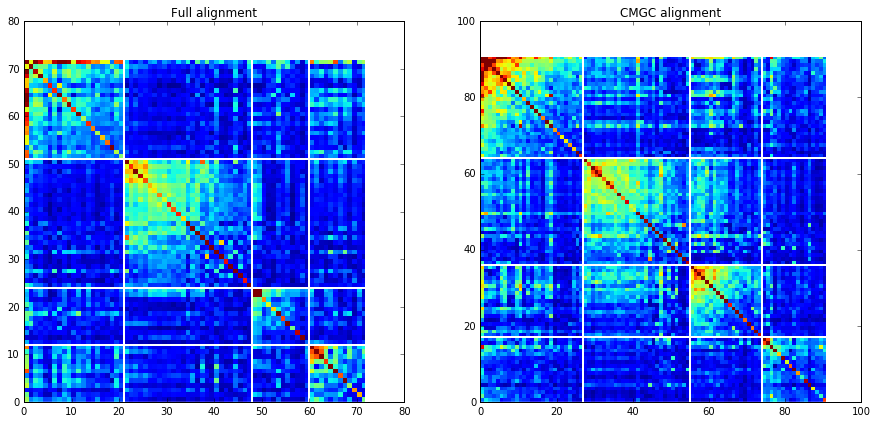

In [109]:
#plot the SCA positional correlation matrix, ordered by contribution to the top ICs
plt.rcParams['figure.figsize'] = 15, 15 
for k in range(len(alnLabels)):
    Dsca = allResults[alnLabels[k]][0].Dsca
    Dsect = allResults[alnLabels[k]][0].Dsect
    plt.subplot(1,len(alnLabels),k+1)
    plt.imshow(Dsca['Csca'][np.ix_(Dsect['sortedpos'], Dsect['sortedpos'])], \
           vmin=0, vmax=2,interpolation='none',\
           aspect='equal',extent=[0,sum(Dsect['icsize']),\
                                  0,sum(Dsect['icsize'])])
    line_index=0
    for i in range(Dsect['kpos']):
        plt.plot([line_index+Dsect['icsize'][i],line_index+Dsect['icsize'][i]],\
             [0,sum(Dsect['icsize'])],'w', linewidth = 2)
        plt.plot([0,sum(Dsect['icsize'])],[sum(Dsect['icsize'])-\
            line_index,sum(Dsect['icsize'])-line_index],'w', linewidth = 2)
        line_index += Dsect['icsize'][i] 
    plt.title(alnLabels[k])

In these matrices, pixel intensity provides a measure of the co-evolution between a particular pair of amino acid positions. Overall, the strength of positional coevolution computed for the CMGC alignment *(right matrix)* is higher than for the full alignment *(left matrix)*, and the number of sector positions is larger. Both of these are consistent with the overall higher sequence conservation observed in the CMGC-specific kinase alignment (remember that the covariance matrix is weighted by conservation).

#### Below we list the sector positions (sorted by IC) in a format suitable for cut-and-paste into pymol. The residue numberings are for PDBID: 2PK9 (yeast Pho85)

In [110]:
#sector positions (broken down by ic) for the two different alignments
for k in range(len(alnLabels)):
    print('Sector positions for '+alnLabels[k]+", cutoff 0.95 : ")
    tmp_pos = []
    tmp_pos_ix = []
    for n,ipos in enumerate(allResults[alnLabels[k]][0].Dsect['ics']):
        sort_ipos = sorted(ipos.items)
        ats_ipos = ([allResults[alnLabels[k]][0].Dseq['ats'][s] for s in sort_ipos])
        ic_pymol = ('+'.join(ats_ipos))
        tmp_pos = tmp_pos + [int(j) for j in ats_ipos]
        tmp_pos_ix = tmp_pos_ix + sort_ipos
        print('IC %i is composed of %i positions:' % (n+1,len(ats_ipos)))
        print(ic_pymol + "\n")

Sector positions for Full alignment, cutoff 0.95 : 
IC 1 is composed of 21 positions:
7+17+18+24+35+50+52+70+72+79+82+87+88+118+124+139+173+193+282+285+294

IC 2 is composed of 27 positions:
14+16+19+21+33+34+36+53+62+64+66+83+89+123+131+132+133+138+140+148+151+152+153+177+178+191+194

IC 3 is composed of 12 positions:
57+81+121+125+129+135+136+155+200+277+278+286

IC 4 is composed of 12 positions:
68+80+85+120+154+171+174+189+195+196+201+295

Sector positions for CMGC alignment, cutoff 0.95 : 
IC 1 is composed of 27 positions:
18+37+52+62+64+68+71+79+88+120+125+132+154+155+156+166+169+171+173+180+200+211+217+221+227+270+296

IC 2 is composed of 28 positions:
7+14+16+21+34+36+53+57+83+131+133+135+136+138+151+153+177+178+186+191+193+196+209+226+272+285+291+294

IC 3 is composed of 19 positions:
19+24+33+89+116+134+140+148+152+174+175+176+197+198+201+208+210+228+282

IC 4 is composed of 17 positions:
17+22+35+47+49+66+82+84+111+124+145+168+172+233+234+295+297



We group all four IC's into a single sector, with the view that this is the most conservative interpretation in the absence of experimental/biological data supporting the model of multiple independent regiouns in the kinase.

#### We may also define sector positions for the other IC CDF cutoffs:

In [111]:
secPos2PK9 = {}
for aln in alnLabels:
    secList = []
    for k in (range(len(IC_CDFcutoff))):        
        secpos =  sorted(allResults[aln][k].Dsect['sortedpos'])
        secpostmp = [allResults[aln][k].Dseq['ats'][pos] for pos in secpos]
        secList.append(secpostmp)
        print "sector for %s, IC CDF = %s (%i pos, %1.2f of the kinase):" % \
            (aln,IC_CDFcutoff[k], len(secpostmp),
             len(secpostmp)/len(allResults[aln][k].Dseq['ats']))
        print "+".join(secpostmp)
    secPos2PK9[aln] = secList

sector for Full alignment, IC CDF = 095 (72 pos, 0.36 of the kinase):
7+14+16+17+18+19+21+24+33+34+35+36+50+52+53+57+62+64+66+68+70+72+79+80+81+82+83+85+87+88+89+118+120+121+123+124+125+129+131+132+133+135+136+138+139+140+148+151+152+153+154+155+171+173+174+177+178+189+191+193+194+195+196+200+201+277+278+282+285+286+294+295
sector for Full alignment, IC CDF = 096 (61 pos, 0.31 of the kinase):
7+14+16+19+21+24+34+35+36+50+52+53+57+62+64+68+72+79+80+82+83+85+87+88+118+120+121+124+125+129+131+132+133+135+136+138+140+148+151+152+153+154+155+171+173+174+177+178+191+193+194+195+196+201+277+278+282+285+286+294+295
sector for Full alignment, IC CDF = 097 (47 pos, 0.24 of the kinase):
7+14+16+21+24+34+36+50+52+53+57+62+64+68+72+82+87+88+118+120+121+124+125+131+132+133+135+136+138+148+151+152+153+155+171+174+177+191+193+196+201+277+278+282+285+286+295
sector for Full alignment, IC CDF = 098 (19 pos, 0.10 of the kinase):
24+50+52+72+82+87+88+121+125+135+171+174+193+196+201+278+282+285+295
sector 

The sector (as defined using either alignment) forms a physically contigous network through the kinase catalytic domain tertiary structure when visualized on the 2PK9 PDB. The CMGC-alignment sector includes the majority of the smaller sector computed for the full alignment, as well as several additional structural "arms". These arms extend out to (1) an C-lobe insertion conserved among the CMGC kinases and (2) the MAPK specific docking groove (see also Fig. 4E, Pincus et al). The overlap between the two sectors is highly statistically significant (we test this via Fisher exact below)

In [112]:
# a comparison of the sector positions calculated using the two different alignments
alnpos_intersect = set(allResults[alnLabels[0]][0].Dseq['ats']).intersection(allResults[alnLabels[1]][0].Dseq['ats']) #positions that are included in both alignment
secPos2PK9both = {}  #subset of sector positions that are present in both alignments

for k in alnLabels:
    tmp = [str(p) for p in secPos2PK9[k][0]]
    secPos2PK9both[k] = set(tmp).intersection(alnpos_intersect)

for k in alnLabels:
    print ("%s has %i sector positions (%i that are present in both alignments)"% \
           (k,len(secPos2PK9[k][0]),len(secPos2PK9both[k])))
    print ("The sector is %1.2f of the alignment positions." % \
          (len(secPos2PK9[k][0])/len(allResults[k][0].Dseq['ats'])))

p_val, cont_table = compStatAssoc(secPos2PK9both[alnLabels[0]], secPos2PK9both[alnLabels[1]], \
                         alnpos_intersect, v = 1, cat1 = 'full alignment sector', cat2 = 'CMGC alignment sector')    
print ("P-val (by Fisher exact test): %e" % p_val)

Full alignment has 72 sector positions (72 that are present in both alignments)
The sector is 0.36 of the alignment positions.
CMGC alignment has 91 sector positions (80 that are present in both alignments)
The sector is 0.33 of the alignment positions.
There are 54 positions which are both in full alignment sector and CMGC alignment sector
There are 18 positions which are in full alignment sector but not CMGC alignment sector
There are 26 which are in CMGC alignment sector but not full alignment sector
There are 97 positions which are neither full alignment sector or CMGC alignment sector
P-val (by Fisher exact test): 1.146226e-13


## II. Conserved Positions 

In addition to defining sectors, we also define a set of conserved positions for comparison. Conservation is computed using the Kullback-Leibler relative entropy (D_i), as described in Rivoire O. et al. We plot: 1) a bar graph of the conservation of each position, the red line indicates the mean conservation (averaged across all positions), 2) a histogram of the distribution of conservation values. Position numbers refer to PDB: 2PK9

We define conserved positions at several K-L relative entropy cutoffs - these include conserved and moderately conserved residues, and are chosen to give a number of positions comparable in size to the sector.  As expected: 1) the *CMGC alignment* contains more conserved positions than the full alignment and 2) for *both alignments* the overlap between conserved positions and the sector is large.

Conserved positions Di= 1.00 (0.240-0.995 freq), Full alignment: 72, 0.36 of the protein
7+13+14+16+18+19+21+22+24+33+34+35+36+50+53+54+57+62+64+65+66+68+80+81+82+83+84+85+88+89+93+120+121+123+124+125+129+130+131+132+133+134+135+136+138+139+140+141+142+148+149+150+151+152+153+154+155+156+173+174+176+177+178+191+192+193+194+196+197+201+285+295
Conserved positions Di= 1.15 (0.240-0.995 freq), Full alignment: 60, 0.30 of the protein
7+13+14+16+18+19+21+22+24+33+34+35+36+53+62+64+65+66+80+81+82+83+84+85+88+89+120+121+123+124+125+129+131+132+133+134+135+136+138+139+140+142+148+149+151+152+153+155+173+174+176+177+178+191+192+193+194+196+197+201
Conserved positions Di= 1.30 (0.240-0.995 freq), Full alignment: 44, 0.22 of the protein
14+16+18+19+21+22+24+33+34+36+53+62+64+66+81+82+83+84+85+88+89+120+123+125+131+132+133+135+136+138+140+148+151+152+153+155+176+177+178+191+192+193+194+196
Conserved positions Di= 2.00 (0.700-0.995 freq), Full alignment: 23, 0.12 of the protein
14+16+21+34+36+53+62

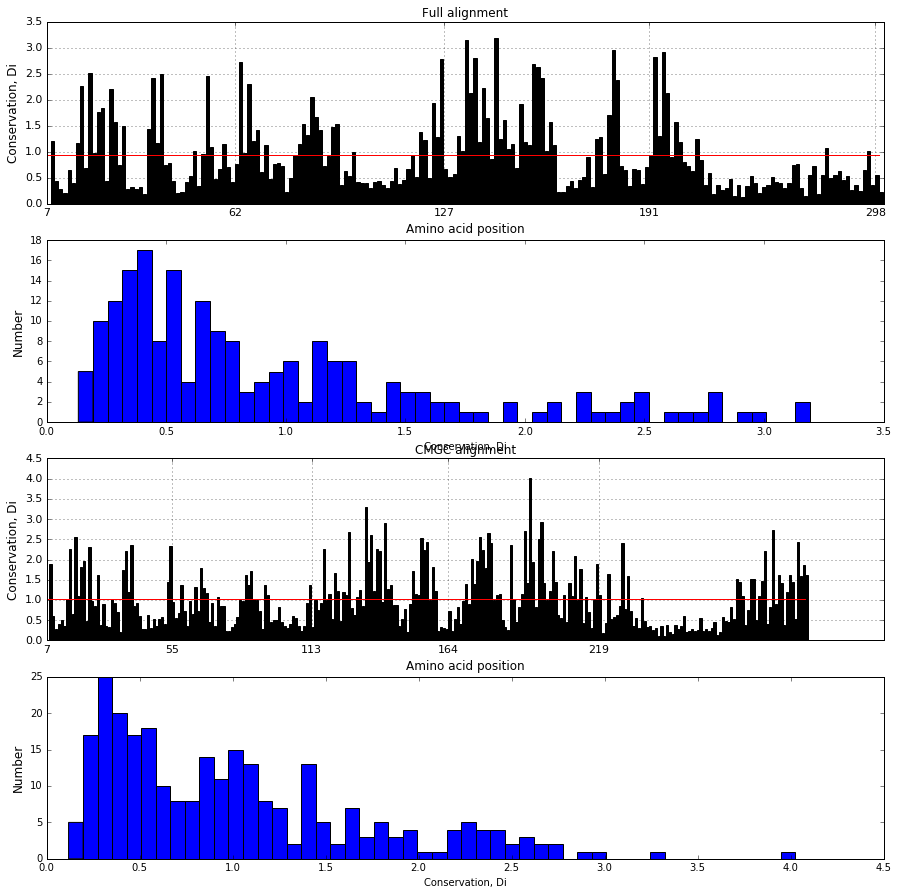

In [113]:
plt.rcParams['figure.figsize'] = 15, 15 
consPos2PK9 = {}
Di_cutoff = [1.0, 1.15, 1.3, 2.0]
aa = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

for j,label in enumerate(alnLabels):
    axs = plt.subplot(4,1,(j*2)+1)
    xvals = [i+1 for i in range(len(allResults[label][0].Dsca['Di']))]
    xticks = [0,45,95,144,198]
    plt.bar(xvals,allResults[label][0].Dsca['Di'], color='k')
    plt.plot([0,len(allResults[label][0].Dsca['Di'])],\
             [np.mean(allResults[label][0].Dsca['Di']),np.mean(allResults[label][0].Dsca['Di'])],'r')
    plt.tick_params(labelsize=11); plt.grid()
    axs.set_xticks(xticks);
    labels = [allResults[label][0].Dseq['ats'][k] for k in xticks]
    axs.set_xticklabels(labels);
    plt.title(label)
    plt.xlabel('Amino acid position', fontsize=12); plt.ylabel('Conservation, Di', fontsize=12);
    
    plt.subplot(4,1,(j*2)+2)
    plt.hist(allResults[label][0].Dsca['Di'],50)
    plt.xlabel('Conservation, Di'); plt.ylabel('Number', fontsize=12)
    
    consList = []

    for d in range(len(Di_cutoff)):
        consPosTmp = []
        consPosTmpix = []
        dvals = []
        for i,k in enumerate(allResults[label][0].Dsca['Di']):
            if k > Di_cutoff[d]:
                dvals.append(k)
                consPosTmpix.append(i)
                consPosTmp.append(allResults[label][0].Dseq['ats'][i])
        minval = np.where(dvals == min(dvals))
        freq = []
        for ix in consPosTmpix:
            allAA = [allResults[label][0].Dseq['alg'][k][ix] for k \
                    in range(len(allResults[label][0].Dseq['alg']))]
            freq.append(max([len([1 for k in allAA if k==res])/len(allAA) for res in aa]))
        
        print ('Conserved positions Di= %1.2f (%1.3f-%1.3f freq), %s: %i, %1.2f of the protein' % \
               (Di_cutoff[d],min(freq),max(freq),label,len(consPosTmp),len(consPosTmp)/len(allResults[label][0].Dseq['ats'])))
        print '+'.join(consPosTmp)
        consList.append(consPosTmp)
    consPos2PK9[label] = consList

## III. Comparison to kinase spines 

Now that we have defined the sector, we can compare the sector positions to available structural and biochemical data. We begin by comparing to the kinase spines, as described in : Kornev et al. (2008) PNAS v. 105 p.14377 and Kornev et al (2006) PNAS v. 103 p. 17783. The kinase C- and R- spines are two small groups of hydrophobic residues that were identified through the comparison of inactive and active crystallographic structures, and are proposed to play a role in the dynamics of kinase activation. 

We find that the spines are largely encapsulated within the kinase sector, consistent with the idea that both the sector and spines represent conserved allosteric units. (related to Fig. S3)

In [114]:
#Set up some variables for mapping between the 2PK9 structure numbering system, PKA (2CPK.PDB) and our alignments.
#We initialize lists of the sector and conserved positions in 2PK9 in terms of the un-processed alignments.
#(i.e. prior to any filtering to remove gapped positions)
ix_ref = [i for i,k in enumerate(allResults[alnLabels[0]][0].Dseq['hd']) if '2347159' in k]
ix_ref2 = [i for i,k in enumerate(allResults[alnLabels[1]][0].Dseq['hd']) if '2pk9_Sc_CMGC_CDK_CDK5' in k]
PK9trunalnix = [ix_ref[0], ix_ref2[0]] #indices of the PK9 sequences in the processed, analyzed alignments

ATSmap_2PK9, db_ref = {}, {}
ATSmap_2PK9[alnLabels[0]], ix1 = buildATS('masterAln.an','RefTxtFiles/2PK9KinIndex.txt', '2PK9.pos')
db_ref[alnLabels[0]] = pickle.load(open('Outputs/ATS_2PK9.db', 'rb'))
ATSmap_2PK9[alnLabels[1]], ix2 = buildATS('CMGC_KinaseMSA.fasta','RefTxtFiles/2PK9KinIndex_CMGC.txt', '2PK9_CMGCaln.pos')
db_ref[alnLabels[1]] = pickle.load(open('Outputs/ATS_2PK9.db', 'rb'))
PK9alnix = [ix1,ix2]

ixSecPosForMap = {}
ixConsPosForMap = {}
for aln in alnLabels:
    secList, consList = [], []
    for d in range(len(IC_CDFcutoff)):
        secList.append([ATSmap_2PK9[aln].index(k) for k in secPos2PK9[aln][d]])
    for d in range(len(Di_cutoff)):
        consList.append([ATSmap_2PK9[aln].index(k) for k in consPos2PK9[aln][d]])
    ixSecPosForMap[aln] = secList
    ixConsPosForMap[aln] = consList
    
    
#Perform a quick sanity check to make sure the mapping is working as expected... 
print "Checking mapping for the full alignment:"
seqSecFullAln = [db_ref[alnLabels[0]]['sequence']['alg'][PK9alnix[0]][k] for k in ixSecPosForMap[alnLabels[0]][0]]
sector_ix = [allResults[alnLabels[0]][0].Dseq['ats'].index(k) for k in secPos2PK9[alnLabels[0]][0]]
seqSecFullAln_Trun = [allResults[alnLabels[0]][0].Dseq['alg'][PK9trunalnix[0]][k] for k in sector_ix]
if seqSecFullAln_Trun == seqSecFullAln: print 'mapping for full alignment is good'
else: print 'mapping for full alignment failed'

print "Checking mapping for the CMGC alignment:"
seqSecCMGCAln = [db_ref[alnLabels[1]]['sequence']['alg'][PK9alnix[1]][k] for k in ixSecPosForMap[alnLabels[1]][0]]
sector_ix = [allResults[alnLabels[1]][0].Dseq['ats'].index(k) for k in secPos2PK9[alnLabels[1]][0]]
seqSecCMGCAln_Trun = [allResults[alnLabels[1]][0].Dseq['alg'][PK9trunalnix[1]][k] for k in sector_ix]
if seqSecCMGCAln_Trun == seqSecCMGCAln: print 'mapping for CMGC alignment is good'
else: print 'mapping for CMGC alignment failed'

./scaMakeATS.py Inputs/masterAln.an -i 6072 -o Refpos/2PK9.pos --output Outputs/ATS_2PK9 > Outputs/ATS_2PK9.log
./scaMakeATS.py Inputs/CMGC_KinaseMSA.fasta -i 248 -o Refpos/2PK9_CMGCaln.pos --output Outputs/ATS_2PK9 > Outputs/ATS_2PK9.log
Checking mapping for the full alignment:
mapping for full alignment is good
Checking mapping for the CMGC alignment:
mapping for CMGC alignment is good


In [115]:
#map the sector positions to the mouse CAMP-dependent protein kinase (PKA) structure
#we only examine the sector positions for the full alignment, since PKA is not part of the CMGC group
ATSmap_PKA, PKAalnix = buildATS('masterAln.an', 'RefTxtFiles/PKAKinIndex.txt')

print "PKA sector (PDB: 2CPK): "
secPosPKA = [ATSmap_PKA[k] for k in ixSecPosForMap[alnLabels[0]][0] if ATSmap_PKA[k] != '-']
print '+'.join(secPosPKA)

tmpLines=open('RefTxtFiles/Spines_reslist.txt','r').readlines()
spineRes = [(k.split()[1]) for k in tmpLines]
print('There are %i residues in spines, %i are in the sector.' %\
      (len(spineRes), len(set(spineRes).intersection(secPosPKA))))
print'Spine positions: '+'+'.join(spineRes)
print('These residues are non-sector:')
print set(spineRes).difference(secPosPKA)

./scaMakeATS.py Inputs/masterAln.an -i 4138 -o Refpos/2CPK.pos --output Outputs/ATS_2CPK > Outputs/ATS_2CPK.log
PKA sector (PDB: 2CPK): 
43+50+52+53+54+55+57+60+69+70+71+72+88+90+91+95+100+102+104+106+109+111+117+118+119+120+121+123+125+126+128+147+149+154+156+157+158+162+164+165+166+168+169+171+172+173+181+184+185+186+187+188+198+200+201+207+208+215+220+222+223+225+226+230+231+272+273+277+280+281+294+295
There are 13 residues in spines, 11 are in the sector.
Spine positions: 95+106+164+185+220+231+227+128+172+173+174+57+70
These residues are non-sector:
set(['227', '174'])


## IV. Association between the sector and mutational data for ERK2

A recently published data set provides functional measurements for a saturation mutagenesis library over nearly all positions of H. sapiens ERK2 - a homolog to KSS1 (Brenan et al. (2016) Cell Reports v. 17 p.1171). The mutations were assessed for their ability to enhance proliferation (implying ERK2 loss-of-function) or diminish proliferation (implying ERK2 gain-of-function) in the background of the A375 cell line (containing the BRAFV600E mutation).

We show that mutation of ERK2 sector positions is often associated with enhanced proliferation (LOF). Accordingly, if we focus on only the ERK2 surface positions, we also observe a statistically signficant relationship between sector-connected positions, and LOF mutations. Further, there is a statistically significant relationship between sector connected positions and mutations that provide resistance to the ERK inhibitors SCH772984 and VRT-11E. Taken together, these data support the idea that the sector is enriched for positions involved in kinase function. Related to Fig. 4, Fig. S4, Table S5

#### IVa. We start by reading in the data, mapping it to the ERK2 structure and constructing a few plots:

In [116]:
#setup a good colormap for plotting the mutational data matrix, and color-coding the structure
f = open('Inputs/rwb.cmap')
ln = f.readlines()
C = np.zeros([len(ln),3])
for j,line in enumerate(ln):
    sp = line.split()
    for k,val in enumerate(sp):
        C[j,k] = float(val)
bwr2 = matplotlib.colors.ListedColormap(C/255.0)

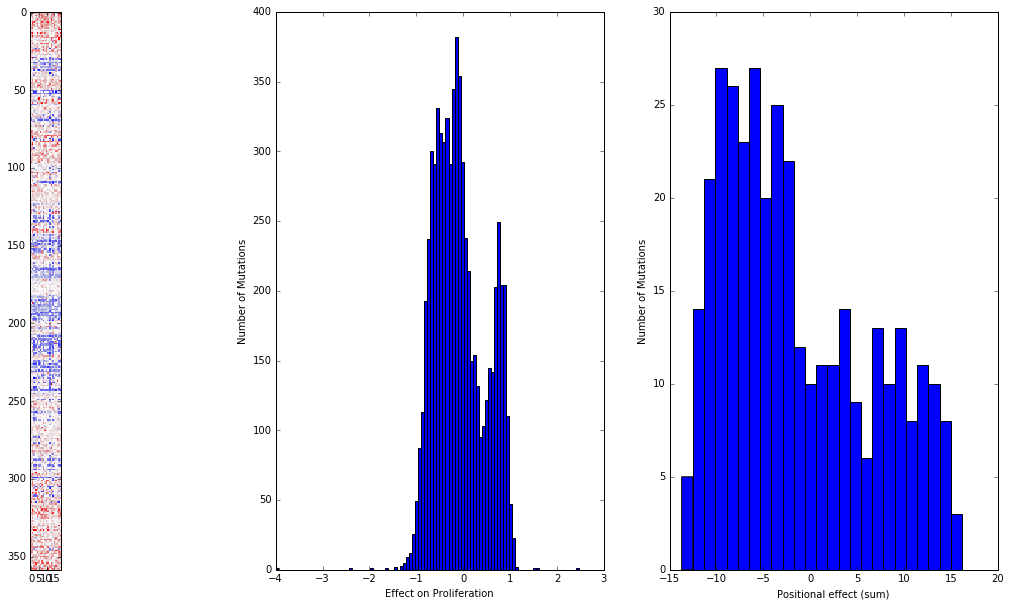

In [117]:
#read in the functional mutation data and make a few plots
f = open('RefTxtFiles/ERK2_SatMutData.txt')
MutData = f.readlines()
pos, reswt, resmut, LFC, LFC_p = [],[],[],[],[]

for line in MutData:
    sp = line.split()
    pos.append(sp[0])
    reswt.append(sp[1])
    resmut.append(sp[2])
    LFC.append(float(sp[3]))
    LFC_p.append(float(sp[4]))

ERK2posHS = [int(k) for k in set(pos)]
ERK2posHS.sort()
ERK2posRN = [ERK2posHS[k] for k in range (0,8)] #converting to Rat numbering system (for mapping to PDB/ats)
ERK2posRN = ERK2posRN + [0,0]+ [ERK2posHS[k]-2 for k in range(10,len(ERK2posHS))]
ERK2posRN = [str(k) for k in ERK2posRN]
mutMatrix = np.zeros([len(ERK2posHS),20])
for k in range(len(pos)):
    ixPos = ERK2posHS.index(int(pos[k]))
    ixMut = aa.index(resmut[k])
    mutMatrix[ixPos,ixMut] = LFC[k] 
    
plt.rcParams['figure.figsize'] = 20, 10               

plt.subplot(131)
plt.imshow(mutMatrix, vmin=-1.2, vmax=1.2, interpolation = 'none', cmap=bwr2); 
#plt.colorbar()
plt.subplot(132)
plt.hist(LFC, 100)
plt.xlabel('Effect on Proliferation'); plt.ylabel('Number of Mutations')
plt.subplot(133)
plt.hist(mutMatrix.sum(1), 25)
plt.xlabel('Positional effect (sum)'); plt.ylabel('Number of Mutations')
#plt.savefig('Plots/MutData.pdf')

The heatmap at left shows the mutational effect for every amino acid (horizontal axis) at every position (vertical axis). The color-coding is such that blue = enhanced proliferation, red = reduced proliferation.

In the middle panel, we reproduce the distribution of mutational effects described by Brenan et al. In the right panel, we plot the distribution of positional mutation effects (the effect of mutation at a single position summed across all substitutions, referred to as the "phenotypic score" by Brenan et al.) Notably, the mutational effects are not unimodal and centered around 0 (as observed for a number of other protein saturation mutagenesis scans). Rather the majority of mutations seem to result in some phenotype.

#### IVb. Prior to comparing the data to the sector, we first examine how mutational effects relate to conservation.

./scaMakeATS.py Inputs/masteraln.an -i 4190 -o Refpos/2ERK.pos --output Outputs/ATS_2ERK > Outputs/ATS_2ERK.log
./scaMakeATS.py Inputs/CMGC_KinaseMSA.fasta -i 392 -o Refpos/2ERK_CMGCaln.pos --output Outputs/ATS_2ERK > Outputs/ATS_2ERK.log


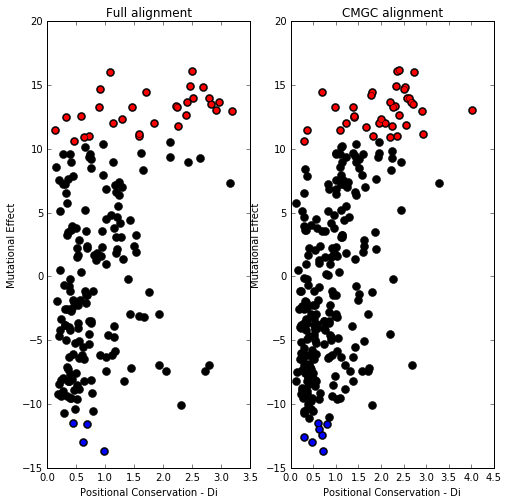

In [118]:
plt.rcParams['figure.figsize'] = 8,8 
consMutPos = []
fxnEffMutPos = []

ATSmap_ERK2 = {}
ats,ix = buildATS('masteraln.an', 'RefTxtFiles/ERK2KinIndex.txt')
ATSmap_ERK2[alnLabels[0]] = ats
ats,ix = buildATS('CMGC_KinaseMSA.fasta', 'RefTxtFiles/ERK2KinIndex_CMGC.txt', '2ERK_CMGCaln.pos')
ATSmap_ERK2[alnLabels[1]] = ats

#as defined in Brenan et al. - R. norvegicus numbering system
LOFposRN = [183,218,169,203,214,230,257,134,30,191,35,170,226,188,186,189,195,152,\
            210,149,185,109,37,208,194,50,147,32,228,193,231,213,165,69,299,52,243]
GOFposRN = [79,83,8,333,56,47,358,16,354,13,320,58,3,350,7,140,24,15,319]

for a,aln in enumerate(alnLabels):
    posvals, consvals = [], []
    posvalsGOF, consvalsGOF = [], []
    posvalsLOF, consvalsLOF = [], []
    for i,k in enumerate(ERK2posRN):
        if str(k) in ATSmap_ERK2[aln]: 
            posix = ATSmap_ERK2[aln].index(k)
            posin2PK9 = db_ref[aln]['sequence']['ats'][posix]
            if posin2PK9 in allResults[aln][0].Dseq['ats']:
                ixForSCA = allResults[aln][0].Dseq['ats'].index(posin2PK9)
                posvals.append(mutMatrix[i,:].sum())
                consvals.append(allResults[aln][0].Dsca['Di'][ixForSCA])
                if int(k) in LOFposRN:
                    posvalsLOF.append(posvals[-1])
                    consvalsLOF.append(consvals[-1])
                if int(k) in GOFposRN:
                    posvalsGOF.append(posvals[-1])
                    consvalsGOF.append(consvals[-1])
                #print ('ERK2: '+db_ref[a]['sequence']['alg'][ERK2alnix[a]][posix]+str(k))
                #print ('2PK9 - full:'+db_ref[a]['sequence']['alg'][PK9alnix[a]][posix]+posin2PK9)
                #print ('2PK9 - trun: '+Dseq[a]['alg'][PK9trunalnix[a]][ixForSCA]+posin2PK9)
                #print Dsca[a]['Di'][ixForSCA]
    consMutPos.append(consvals)
    fxnEffMutPos.append(posvals)
    plt.subplot(1,2,a+1)
    plt.plot(consMutPos[a],fxnEffMutPos[a],'ok', markersize=8)
    plt.plot(consvalsLOF, posvalsLOF, 'or', markersize = 6)
    plt.plot(consvalsGOF, posvalsGOF, 'ob', markersize = 6)
    plt.title(aln)
    plt.xlabel('Positional Conservation - Di')
    plt.ylabel('Mutational Effect')

Mutations at conserved positions do tend to have an effect on proliferation (it may be in either the direction of LOF or GOF).  Functional effects are also observed at less conserved positions.

#### IVc. To visualize the mutational effects on the ERK2 structure, we write out a couple of pymol scripts that color-code (1) all positions, or (2) surface positions, by the mutational effect summed across all substitutions. 

In [119]:
f = open('Pymol/ColorERK2AllMut.pml', "wb")
f2 = open('Pymol/ColorERK2SurfMut.pml', "wb")
fxnEffMutPosAll = mutMatrix.sum(1)
minEff, maxEff = min(fxnEffMutPosAll), max(fxnEffMutPosAll)
fSurf = open('RefTxtFiles/2ERK_SurfPos.txt', 'r')
tmp = fSurf.readlines(); fSurf.close()
ERK2surfRN = tmp[0].split()

selStr = ''
selStrSurf = ''
for k in ERK2posRN:
    if k in range(6,359):
        selStr = selStr + k + "+"
    if str(k) in ERK2surfRN:
        selStrSurf = selStrSurf + k + "+"
        
f.write("create allMutERK2, 2ERK \n")
f2.write("create surfMutERK2, 2ERK and resi "+selStrSurf+"\n")
        
for i,k in enumerate(ERK2posRN):
    if k != '0':
        f.write('show spheres, allMutERK2 and resi '+str(k)+'\n')
        colScale = bwr2((fxnEffMutPosAll[i] - minEff)/maxEff)
        #convert from rgba to rgb (w/ white bg)
        colScale2 = []
        for c in range(3):
            colScale2.append((1 - colScale[3]) + (colScale[3] * colScale[c]))
        f.write('set_color colres'+k+', [%1.4f,%1.4f,%1.4f]\n'%(colScale2[0], colScale2[1], colScale2[2]))
        f.write('color colres'+k+', allMutERK2 and resi '+k+'\n')
        if k in ERK2surfRN:
            f2.write('show spheres, surfMutERK2 and resi '+k+'\n')
            f2.write('set_color colres'+k+', [%1.4f,%1.4f,%1.4f]\n'%(colScale2[0], colScale2[1], colScale2[2]))
            f2.write('color colres'+k+', surfMutERK2 and resi '+k+'\n')
f.close()
f2.close()

#### IVd. Map the sector to the ERK2 structure (see Fig. 4C,E)

In [120]:
secPosERK2 = {}
for aln in alnLabels:
    secList = []
    for d in range(len(IC_CDFcutoff)):
        secList.append([ATSmap_ERK2[aln][k] for k in ixSecPosForMap[aln][d] if ATSmap_ERK2[aln][k] != '-'])
    secPosERK2[aln] = secList
    
print "ERK2 sector, 0.95 cutoff, full alignment (PDB: 2ERK, R. norvegicus numbering): "
print '+'.join(secPosERK2[alnLabels[0]][0])
print "ERK2 sector, 0.95 cutoff, CMGC alignment (PDB: 2ERK, R. norvegicus numbering): "
print '+'.join(secPosERK2[alnLabels[1]][0])
print ("ERK2 sector full alignment: %i pos, CMGC alignment: %i pos" % (len(secPosERK2[alnLabels[0]][0]), \
                                                                       len(secPosERK2[alnLabels[1]][0])))

ERK2 sector, 0.95 cutoff, full alignment (PDB: 2ERK, R. norvegicus numbering): 
23+30+32+33+34+35+37+40+49+50+51+52+66+68+69+73+78+80+82+84+93+100+101+102+103+104+106+108+109+110+128+130+135+137+138+139+143+145+146+147+149+150+152+153+154+162+165+166+167+168+169+185+187+188+194+195+203+208+210+211+213+214+218+219+291+292+296+299+300+308+309
ERK2 sector, 0.95 cutoff, CMGC alignment (PDB: 2ERK, R. norvegicus numbering): 
23+30+32+33+34+35+37+38+40+49+50+51+52+53+63+65+68+69+73+78+80+82+84+87+100+103+104+105+109+110+125+130+134+138+139+145+146+147+148+149+150+152+154+159+162+165+166+167+168+169+170+182+185+186+188+189+190+191+192+193+194+195+197+203+208+210+213+214+215+217+218+225+226+227+228+234+238+243+244+245+250+251+284+286+296+299+305+308+309+310+311
ERK2 sector full alignment: 71 pos, CMGC alignment: 91 pos


#### Also, plot conservation for each position in the 2ERK (R. norvegicus) structure, (for Fig. 4D).

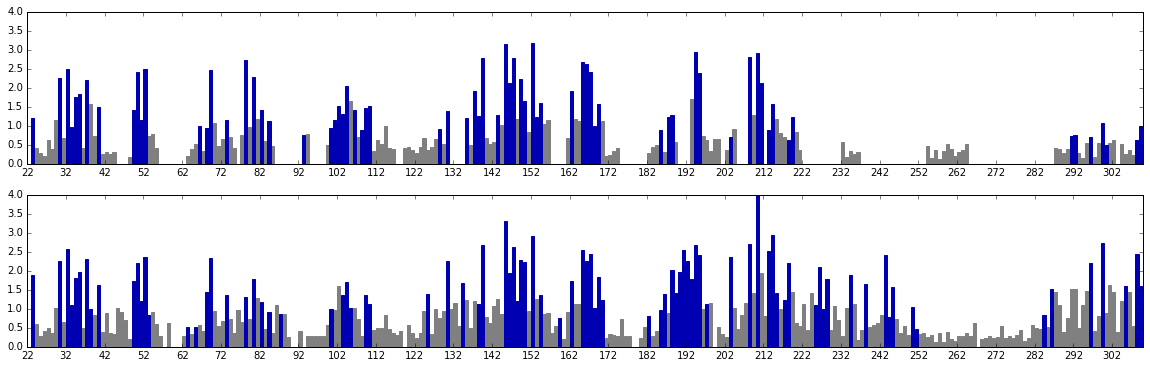

In [121]:
plt.rcParams['figure.figsize'] = 20,6
ERK2posRNstruct = [str(k) for k in range(2,355)]

for a,aln in enumerate(alnLabels):
    ERK2Di_sect = [] ; ERK2Di_nonsect = []
    ERK2pos_sect = [] ; ERK2pos_nonsect = []
    for i,k in enumerate(ERK2posRNstruct):
        if (k in ATSmap_ERK2[aln]):
            posix = ATSmap_ERK2[aln].index(k)
            posin2PK9 = db_ref[aln]['sequence']['ats'][posix]
            if posin2PK9 in allResults[aln][0].Dseq['ats']:
                ixForSCA = allResults[aln][0].Dseq['ats'].index(posin2PK9)
                if str(k) in secPosERK2[aln][0]:
                    ERK2Di_sect.append(allResults[aln][0].Dsca['Di'][ixForSCA])
                    ERK2pos_sect.append(k)
                else:
                    ERK2Di_nonsect.append(allResults[aln][0].Dsca['Di'][ixForSCA])
                    ERK2pos_nonsect.append(k)
            else:
                ERK2Di_nonsect.append(0)
                ERK2pos_nonsect.append(k)
        else:
            ERK2Di_nonsect.append(0)
            ERK2pos_nonsect.append(k)

    plt.subplot(2,1,a+1)        
    plt.bar(ERK2pos_nonsect,ERK2Di_nonsect, color=[0.5, 0.5, 0.5], edgecolor = [0.5,0.5,0.5])
    plt.bar(ERK2pos_sect,ERK2Di_sect,color =[0,0,0.7], edgecolor = [0,0,0.7])
    plt.xlim(22,310); plt.ylim(0,4)
    plt.xticks(range(22,310,10))

#plt.savefig('Plots/ERK2Conservation.pdf')

#### IVe. Now, quantitatively examine the association between the sector, sector-connected positions,  and mutations with an effect on proliferation.

In [122]:
#read in the distance matrix for the ERK2 structure
f = open('RefTxtFiles/2ERKdistats.txt', 'r')
tmp = f.readlines(); f.close()
ERK2distats = tmp[0].rstrip().split(',')

#read in the distance matrix (calculated using a homology model of KSS1)
ERK2distmat = readDistMat('RefTxtFiles/2ERKdistmat.txt')

#mutations with a functional effect
ERK2GOF = [pos for k,pos in enumerate(ERK2posRN) if (fxnEffMutPosAll[k] < -10) & (pos != '0')]
ERK2LOF = [pos for k,pos in enumerate(ERK2posRN) if (fxnEffMutPosAll[k] > 10) & (pos != '0')]
ERK2FxnBoth = (ERK2GOF + ERK2LOF); ERK2FxnBoth.sort

ERK2GOFSurf = set(ERK2GOF).intersection(ERK2surfRN)
ERK2LOFSurf = set(ERK2LOF).intersection(ERK2surfRN)
ERK2FxnBothSurf = set(ERK2FxnBoth).intersection(ERK2surfRN)

#examine the association between the sector and LOF/GOF mutations
print "** Association between sector and LOF/GOF mutations: *********"
cont_Erk2Sec = {}
for aln in alnLabels:
    cTable = []
    for d in range(len(IC_CDFcutoff)):
        p_val,cTab_tmp = compStatAssoc(set(secPosERK2[aln][d]), set(ERK2LOF), \
                        set(ERK2posRN), v = 0, cat1 = 'sector', cat2 = 'LOF mutants') 
        cTable.append(cTab_tmp)
        print "p-value sector/LOF mutations, alignment %s, cutoff %s: %1.2e" % (aln,IC_CDFcutoff[d],p_val)
        p_val,cTab_tmp = compStatAssoc(set(secPosERK2[aln][d]), set(ERK2FxnBoth), \
                        set(ERK2posRN), v = 0, cat1 = 'sector', cat2 = 'both LOF/GOF mutants') 
        print "p-value sector/LOF+GOF mutations, alignment %s, cutoff %s: %1.2e" % (aln,IC_CDFcutoff[d],p_val)
    cont_Erk2Sec[aln] = cTable
    
#focusing on surface sites (testing the idea of hot spots)
print "\n\n** Association between sector-connected surface sites and LOF/GOF mutations: *********"
for aln in alnLabels:
    for d in range(len(IC_CDFcutoff)):
        secConn = findContacts(ERK2distmat,ERK2distats,secPosERK2[aln][d])
        secConnSurf = set(secConn).intersection(ERK2surfRN)
        p_val,cTab_tmp = compStatAssoc(set(secConnSurf), set(ERK2LOF), \
                        set(ERK2surfRN), v = 0, cat1 = 'sector', cat2 = 'LOF mutants') 
        print "p-value sector/LOF mutations, alignment %s, cutoff %s: %1.2e" % (aln,IC_CDFcutoff[d],p_val)
        p_val,cTab_tmp = compStatAssoc(set(secConnSurf), set(ERK2FxnBoth), \
                        set(ERK2surfRN), v = 0, cat1 = 'sector', cat2 = 'both LOF/GOF mutants') 
        print "p-value sector/LOF+GOF mutations, alignment %s, cutoff %s: %1.2e" % (aln,IC_CDFcutoff[d],p_val)

** Association between sector and LOF/GOF mutations: *********
p-value sector/LOF mutations, alignment Full alignment, cutoff 095: 5.34e-11
p-value sector/LOF+GOF mutations, alignment Full alignment, cutoff 095: 1.17e-03
p-value sector/LOF mutations, alignment Full alignment, cutoff 096: 5.68e-11
p-value sector/LOF+GOF mutations, alignment Full alignment, cutoff 096: 3.48e-04
p-value sector/LOF mutations, alignment Full alignment, cutoff 097: 8.97e-11
p-value sector/LOF+GOF mutations, alignment Full alignment, cutoff 097: 6.90e-05
p-value sector/LOF mutations, alignment Full alignment, cutoff 098: 2.80e-04
p-value sector/LOF+GOF mutations, alignment Full alignment, cutoff 098: 3.40e-02
p-value sector/LOF mutations, alignment CMGC alignment, cutoff 095: 2.27e-19
p-value sector/LOF+GOF mutations, alignment CMGC alignment, cutoff 095: 9.51e-06
p-value sector/LOF mutations, alignment CMGC alignment, cutoff 096: 4.41e-20
p-value sector/LOF+GOF mutations, alignment CMGC alignment, cutoff 096

The relationship between the sector and LOF mutants is highly statistically significant. Further, the relationship between sector connected surface sites and surface LOF mutations is also significant. But the mutations that decrease proliferation (implying GOF) seem to be poorly explained by the sector. Related to Table S5.

#### IVf. The same analysis for the relationship between conserved positions and the ERK2 LOF mutations

In [123]:
#map the conserved positions to the ERK2 structure
consPosERK2 = {}
for aln in alnLabels:
    consList = []
    for d in range(len(Di_cutoff)):
        consList.append([ATSmap_ERK2[aln][k] for k in ixConsPosForMap[aln][d] if ATSmap_ERK2[aln][k] != '-'])
    consPosERK2[aln] = consList
#print out the most conserved positions (defined on the full alignment, Di cutoff > 2)
print 'Most highly conserved positions:'
print '+'.join(consPosERK2[alnLabels[0]][3])   

#calculate the statistical significance of the association
cont_Erk2Cons = {}
for aln in alnLabels:
    cTable = []
    for d in range(len(Di_cutoff)):
        p_val,cTab_tmp = compStatAssoc(set(consPosERK2[aln][d]), set(ERK2LOF), \
                         set(ERK2posRN), v = 0, cat1 = 'conserved positions', cat2 = 'LOF mutations') 
        cTable.append(cTab_tmp)
        print ('Statistical significance for alignment %s, cutoff=%s:  %1.2e' % (aln,Di_cutoff[d],p_val))
    cont_Erk2Cons[aln] = cTable

Most highly conserved positions:
30+32+37+50+52+69+78+80+104+139+145+146+147+149+152+165+166+167+194+195+208+210+211
Statistical significance for alignment Full alignment, cutoff=1.0:  4.72e-08
Statistical significance for alignment Full alignment, cutoff=1.15:  4.22e-08
Statistical significance for alignment Full alignment, cutoff=1.3:  3.65e-10
Statistical significance for alignment Full alignment, cutoff=2.0:  1.49e-10
Statistical significance for alignment CMGC alignment, cutoff=1.0:  2.81e-16
Statistical significance for alignment CMGC alignment, cutoff=1.15:  3.85e-17
Statistical significance for alignment CMGC alignment, cutoff=1.3:  2.37e-18
Statistical significance for alignment CMGC alignment, cutoff=2.0:  3.40e-18


As expected, there is also a statistically significant relationship between the LOF mutations and conserved positions. 

#### IVg. Examine the relationship between the sector and mutations associated with resistance to ERK inhibitors

To identify mutations associated with small molecule inhibitor (drug) resistance, Brenan et al. repeated their functional assay under two different conditions: in the presence of either SCH772984 or VRT11E.  

In [124]:
f = open('RefTxtFiles/ERK2_DrugResMut.txt', 'rb')
mut = f.readlines()
ERK2ResMutHS = mut[0].split(',')
ERK2ResMutHS.sort()
ERK2ResMutRN = [str(int(k)-2) for k in ERK2ResMutHS]
print "Drug resistant mutations, H. sapiens numbering (PDB: 4QTA/4QTE):"
print '+'.join(ERK2ResMutHS)
print "Drug resistant mutations, R. norvegicus numbering (PDB: 2ERK):"
print '+'.join(ERK2ResMutRN)

for aln in alnLabels:
    for d in range(len(IC_CDFcutoff)):
        secConn = findContacts(ERK2distmat,ERK2distats,secPosERK2[aln][d])
        p_val,cTab_tmp = compStatAssoc(set(secConn), set(ERK2ResMutRN), \
                set(ERK2posRN), v = 0, cat1 = 'sector connected positions', cat2 = 'Resistance mutations') 
        p_val2,cTab_tmp = compStatAssoc(set(secPosERK2[aln][d]), set(ERK2ResMutRN), \
                set(ERK2posRN), v = 0, cat1 = 'sector positions', cat2 = 'Resistance mutations') 
        print ('Statistical significance for alignment %s, cutoff=%s:, %1.2e (%1.2e sector only)' % \
               (aln,IC_CDFcutoff[d],p_val,p_val2))

Drug resistant mutations, H. sapiens numbering (PDB: 4QTA/4QTE):
 100+ 103+ 105+ 110+ 124+ 127+ 15+ 169+ 31+ 32+ 33+ 347+ 35+ 36+ 37+ 38+ 39+ 40+ 43+ 44+ 49+ 51+ 55+ 56+ 57+ 58+ 59+ 60+ 62+ 64+ 65+ 67+ 68+ 69
+ 71+ 75+ 97+ 98+156
Drug resistant mutations, R. norvegicus numbering (PDB: 2ERK):
98+101+103+108+122+125+13+167+29+30+31+345+33+34+35+36+37+38+41+42+47+49+53+54+55+56+57+58+60+62+63+65+66+67+69+73+95+96+154
Statistical significance for alignment Full alignment, cutoff=095:, 8.93e-04 (9.84e-03 sector only)
Statistical significance for alignment Full alignment, cutoff=096:, 3.87e-03 (4.14e-02 sector only)
Statistical significance for alignment Full alignment, cutoff=097:, 1.23e-03 (1.07e-01 sector only)
Statistical significance for alignment Full alignment, cutoff=098:, 7.33e-02 (3.11e-01 sector only)
Statistical significance for alignment CMGC alignment, cutoff=095:, 6.83e-03 (1.75e-02 sector only)
Statistical significance for alignment CMGC alignment, cutoff=096:, 8.13e-03 (7.18

## V. Association between the sector and D/E surface mutations in Kss1

To investigate the hypothesis that acidic surface sites connected to the sector could be "hot spots" for engineering phosphoregulation, we conducted an alanine scan of all 40 D/E residues on the surface of the yeast MAPK Kss1. Here, we show that there is a statistically significant association between the D/E-> Ala mutations that have a functional effect and sector-connected surface positions. Related to Fig. 5, Fig. S5, Table S6.

"Sector-connected" is defined as a position where any atom is within 4.0A of any atom in a sector position.  Surface positions and a distance matrix for all residue pairs in KSS1 (homology model) were computed using the matlab script calcSurfPos_KSS1.m and pdb2dist.m, and we import those values for use here (see also the directory Matlab_SurfDist/). Here are the key details for these calculations:
    - Relative solvent accessible surface area (RSA) was calculated using Michel Sanner's MSMS with a probe size of 1.4A, excluding all water and heteroatoms 
    - Used a cutoff of 20% RSA to define solvent exposed positions
    
    
#### Va. We begin by mapping the sectors to a KSS1 homology model:

In [125]:
ATSmap_KSS1 = {}
KSS1alnix = []
ats,ix = buildATS('masteraln.an', 'RefTxtFiles/KSS1KinIndex.txt')
ATSmap_KSS1[alnLabels[0]] = ats
KSS1alnix.append(ix)
ats,ix = buildATS('CMGC_KinaseMSA.fasta', 'RefTxtFiles/KSS1KinIndex_CMGC.txt', 'KSS1_CMGCaln.pos')
ATSmap_KSS1[alnLabels[1]] = ats
KSS1alnix.append(ix)

secPosKSS1 = {}
for aln in alnLabels:
    secList = []
    for d in range(len(IC_CDFcutoff)):
        secList.append([ATSmap_KSS1[aln][k] for k in ixSecPosForMap[aln][d] if ATSmap_KSS1[aln][k] != '-'])
    secPosKSS1[aln] = secList

print "KSS1 sector, 0.95 cutoff, full alignment (PDB: KSS1 - homology model): "
print '+'.join(secPosKSS1[alnLabels[0]][0])
print "KSS1 sector, 0.95 cutoff, CMGC alignment (PDB: KSS1 - homology model): "
print '+'.join(secPosKSS1[alnLabels[1]][0])
print ("KSS1 sector full alignment: %i pos, CMGC alignment: %i pos" % (len(secPosKSS1[alnLabels[0]][0]),\
                                                                       len(secPosKSS1[alnLabels[1]][0])))

./scaMakeATS.py Inputs/masteraln.an -i 374 -o Refpos/KSS1.pos --output Outputs/ATS_KSS1 > Outputs/ATS_KSS1.log
./scaMakeATS.py Inputs/CMGC_KinaseMSA.fasta -i 390 -o Refpos/KSS1_CMGCaln.pos --output Outputs/ATS_KSS1 > Outputs/ATS_KSS1.log
KSS1 sector, 0.95 cutoff, full alignment (PDB: KSS1 - homology model): 
13+20+22+23+24+25+27+30+39+40+41+42+56+58+59+63+69+71+73+75+78+80+91+92+93+94+95+97+99+100+115+128+130+131+133+134+135+139+141+142+143+145+146+148+149+150+158+161+162+163+164+165+185+187+188+194+195+203+208+210+211+213+214+218+219+284+287+288
KSS1 sector, 0.95 cutoff, CMGC alignment (PDB: KSS1 - homology model): 
13+20+22+23+24+25+27+28+30+39+40+41+42+43+53+55+58+59+63+68+71+73+75+78+91+94+95+96+100+101+121+126+130+134+135+141+142+143+144+145+146+148+150+155+158+161+162+163+164+165+166+178+185+186+188+189+190+191+192+193+194+195+197+203+208+210+213+214+215+217+218+225+226+227+228+234+238+243+244+245+250+251+286+288+298+301+307+310+311+312+313
KSS1 sector full alignment: 68 pos, CMG

Again, we see that the KSS1 sector forms a physically contiguous unit on the protein structure. 

#### Vb. Identify the set of sector connected surface D/E residues, and compute the statistical significance of the association between these positions and D/E->Ala mutations with a functional effect.

In [126]:
#read in a list of D/E surface positions for KSS1
f = open('RefTxtFiles/KSS1_SurfDE.txt', 'r')
lines = f.readlines(); f.close()
KSS1surfDE=lines[0].split()
f = open('RefTxtFiles/KSS1distats.txt', 'r')
tmp = f.readlines(); f.close()
KSS1distats = tmp[0].rstrip().split(',')

#experimental results of mutating the surface D/E positions
KSS1surfDE_Fxn = ['8','21','68','70','77','156','117','118','321']

#read in the distance matrix (calculated using a homology model of KSS1)
KSS1distmat = readDistMat('RefTxtFiles/KSS1distmat.txt')

#define which surface D/E positions are sector connected, and compute statistical significance.
cont_Kss1Sec = {}
for aln in alnLabels:
    cTables = []
    for d in range(len(IC_CDFcutoff)):
        secConn = findContacts(KSS1distmat,KSS1distats,secPosKSS1[aln][d])
        #print '+'.join(secConn)
        secConnSurfDE = set(secConn).intersection(KSS1surfDE)
        #print '+'.join(secConnSurfDE)
        p_val,cTab_tmp = compStatAssoc(set(secConnSurfDE), set(KSS1surfDE_Fxn), \
                         set(KSS1surfDE), v = 0, cat1 = 'sector-connected surface site', cat2 = 'functional surface D/E mutants') 
        cTables.append(cTab_tmp)
        print ('Statistical significance for alignment %s, cutoff=%s:  %1.2e' % (aln,IC_CDFcutoff[d],p_val))
    cont_Kss1Sec[aln] = cTables

Statistical significance for alignment Full alignment, cutoff=095:  3.29e-02
Statistical significance for alignment Full alignment, cutoff=096:  2.07e-02
Statistical significance for alignment Full alignment, cutoff=097:  1.90e-01
Statistical significance for alignment Full alignment, cutoff=098:  8.97e-01
Statistical significance for alignment CMGC alignment, cutoff=095:  9.83e-03
Statistical significance for alignment CMGC alignment, cutoff=096:  6.14e-03
Statistical significance for alignment CMGC alignment, cutoff=097:  7.20e-02
Statistical significance for alignment CMGC alignment, cutoff=098:  1.38e-01


So, we see a statistically signficant association between the sector and fuctionally important mutation positions for several sector cutoffs. There is some cutoff dependence, as expected - sectors which are too small miss many of the functional mutations. Additionally, we see that the CMGC alignment is more predictive because it "connects up" two mutations in the MAPK-specific docking groove (D117 and D118) 

#### Vc. Association between conserved positions and mutations in Kss1

The sector positions are also (by definition) relatively conserved. Here we show that connection to moderately conserved residues (without consideration of co-evolution) also serves as a predictor of functional surface sites. 

In [127]:
#map the conserved positions to the KSS1 homology model
consPosKSS1 = {}
for aln in alnLabels:
    consList = []
    for d in range(len(Di_cutoff)):
        consList.append([ATSmap_KSS1[aln][k] for k in ixConsPosForMap[aln][d] if ATSmap_KSS1[aln][k] != '-'])
    consPosKSS1[aln] = consList

#calculate the statistical significance of the association
cont_Kss1Cons = {}
for aln in alnLabels: 
    cTable = []
    for d in range(len(Di_cutoff)):
        consConn = findContacts(KSS1distmat,KSS1distats,consPosKSS1[aln][d])
        consConnSurfDE = set(consConn).intersection(KSS1surfDE)
        p_val, cTab_tmp = compStatAssoc(set(consConnSurfDE), set(KSS1surfDE_Fxn), \
                         set(KSS1surfDE), v = 0, cat1 = 'conservation-connected surface site', cat2 = 'functional surface D/E mutants') 
        cTable.append(cTab_tmp)
        print ('Statistical significance for alignment %s, Di cutoff=%s:  %1.2e' % (aln,Di_cutoff[d],p_val))
    cont_Kss1Cons[aln] = cTable

Statistical significance for alignment Full alignment, Di cutoff=1.0:  1.03e-01
Statistical significance for alignment Full alignment, Di cutoff=1.15:  3.28e-03
Statistical significance for alignment Full alignment, Di cutoff=1.3:  3.28e-03
Statistical significance for alignment Full alignment, Di cutoff=2.0:  8.50e-03
Statistical significance for alignment CMGC alignment, Di cutoff=1.0:  1.52e-02
Statistical significance for alignment CMGC alignment, Di cutoff=1.15:  2.01e-02
Statistical significance for alignment CMGC alignment, Di cutoff=1.3:  2.01e-02
Statistical significance for alignment CMGC alignment, Di cutoff=2.0:  5.04e-01


#### Vd. We also evaluate conservation for a handful of positions near the engineered PTM in Kss1

In [128]:
aln = 'CMGC alignment'
KSS1posoi = ['8','43','91','68','158','95','74','70','129']
ixKSS1posoi = [allResults[aln][0].Dseq['ats'].index(ATSmap_2PK9[aln][ATSmap_KSS1[aln].index(k)]) for k in KSS1posoi]
for i,k in enumerate(ixKSS1posoi):
    print 'pos: '+KSS1posoi[i]+' DI: '+str(allResults[aln][0].Dsca['Di'][k])
    allAA = [allResults[aln][0].Dseq['alg'][s][k] for s in range(len(allResults[aln][0].Dseq['alg']))]
    freq = [len([1 for p in allAA if p==res])/len(allAA) for res in aa]
    print 'Most freq AA: '+aa[freq.index(max(freq))]+' ' +str(max(freq))
 

pos: 8 DI: 0.284840605341
Most freq AA: E 0.113821138211
pos: 43 DI: 0.84517906038
Most freq AA: K 0.465040650407
pos: 91 DI: 1.00552503056
Most freq AA: Y 0.372357723577
pos: 68 DI: 1.31952955959
Most freq AA: H 0.534959349593
pos: 158 DI: 1.72215807602
Most freq AA: K 0.816260162602
pos: 95 DI: 1.71199758626
Most freq AA: E 0.736585365854
pos: 74 DI: 0.468459484851
Most freq AA: K 0.19837398374
pos: 70 DI: 0.719608084312
Most freq AA: P 0.317073170732
pos: 129 DI: 0.538288567731
Most freq AA: R 0.279674796748


## VI. Identifying the set of sector connected D/E surface positions in Hog1

We would like to test if the same principal for engineering phospho-regulation can be applied to another MAPK: Hog1. This kinase is interesting because it is paralogous to Fus3 (but in a different pathway - osmosensing). Hog1 output may be assayed by a transcriptional reporter and physiological output (resistance to osmotic shock). To begin, we identify the set of sector connected D/E surface sites, and use pkaPS to score the consensus PKA site at that position. As for Kss1, we compute surface positions and a distance matrix fo all residues pairs in Hog1 using Matlab and import those values here (see also the directory Matlab_SurfDist/). Related to Fig. 6

In [129]:
ATSmap_HOG1 = {}
HOG1alnix = []
ats,ix = buildATS('masteraln.an', 'RefTxtFiles/HOG1KinIndex.txt')
ATSmap_HOG1[alnLabels[0]] = ats
HOG1alnix.append(ix)
ats,ix = buildATS('CMGC_KinaseMSA.fasta', 'RefTxtFiles/HOG1KinIndex_CMGC.txt', 'HOG1_CMGCaln.pos')
ATSmap_HOG1[alnLabels[1]] = ats
HOG1alnix.append(ix)

secPosHOG1 = {}
for aln in alnLabels:
    secList = []
    for d in range(len(IC_CDFcutoff)):
        secList.append([ATSmap_HOG1[aln][k] for k in ixSecPosForMap[aln][d] if ATSmap_HOG1[aln][k] != '-'])
    secPosHOG1[aln] = secList

print "HOG1 sector, 0.95 cutoff, full alignment (PDB: HOG1): "
print '+'.join(secPosHOG1[alnLabels[0]][0])
print "HOG1 sector, 0.95 cutoff, CMGC alignment (PDB: HOG1): "
print '+'.join(secPosHOG1[alnLabels[1]][0])
print ("HOG1 sector full alignment: %i pos, CMGC alignment: %i pos" % (len(secPosHOG1[alnLabels[0]][0]),\
                                                                       len(secPosHOG1[alnLabels[1]][0])))

./scaMakeATS.py Inputs/masteraln.an -i 4206 -o Refpos/HOG1.pos --output Outputs/ATS_HOG1 > Outputs/ATS_HOG1.log
./scaMakeATS.py Inputs/CMGC_KinaseMSA.fasta -i 455 -o Refpos/HOG1_CMGCaln.pos --output Outputs/ATS_HOG1 > Outputs/ATS_HOG1.log
HOG1 sector, 0.95 cutoff, full alignment (PDB: HOG1): 
23+30+32+33+34+35+37+40+49+50+51+52+67+69+70+74+79+81+83+85+88+90+97+98+99+100+101+103+105+106+107+125+127+132+134+135+136+140+142+143+144+146+147+149+150+151+159+162+163+164+165+166+176+178+179+185+186+194+199+201+202+204+205+209+210+282+283+287+290+291+299+300
HOG1 sector, 0.95 cutoff, CMGC alignment (PDB: HOG1): 
23+30+32+33+34+35+37+38+40+49+50+51+52+53+64+66+69+70+74+79+81+83+85+88+97+100+101+102+106+107+122+127+131+135+136+142+143+144+145+146+147+149+151+156+159+162+163+164+165+166+167+174+176+177+179+180+181+182+183+184+185+186+188+194+199+201+204+205+206+208+209+216+217+218+219+225+229+234+235+236+241+242+275+277+287+290+296+299+300+301+302
HOG1 sector full alignment: 72 pos, CMGC alignmen

In [130]:
#read in a list of D/E surface positions for HOG1
f = open('RefTxtFiles/HOG1_SurfDE.txt', 'r')
lines = f.readlines(); f.close()
HOG1surfDE=lines[0].split()
f = open('RefTxtFiles/HOG1distats.txt', 'r')
tmp = f.readlines(); f.close()
HOG1distats = tmp[0].rstrip().split(',')

#read in the distance matrix (calculated using a homology model of KSS1)
HOG1distmat = readDistMat('RefTxtFiles/HOG1distmat.txt')

#define which surface D/E positions are sector connected, and compute statistical significance.
#cont_HOG1Sec = {}
for aln in alnLabels:
    for d in range(len(IC_CDFcutoff)):
        secConn = findContacts(HOG1distmat,HOG1distats,secPosHOG1[aln][d])
        #print '+'.join(secConn)
        secConnSurfDE = set(secConn).intersection(HOG1surfDE)
        print ('Sector connected D/E positions, alignment %s, cutoff=%s' % (aln,IC_CDFcutoff[d]))
        print '+'.join(secConnSurfDE)

Sector connected D/E positions, alignment Full alignment, cutoff=095
25+195+274+277+280+80+295
Sector connected D/E positions, alignment Full alignment, cutoff=096
25+195+274+277+280+80+295
Sector connected D/E positions, alignment Full alignment, cutoff=097
195+25+80+295+280
Sector connected D/E positions, alignment Full alignment, cutoff=098
195+25+280
Sector connected D/E positions, alignment CMGC alignment, cutoff=095
25+154+195+272+260+274+277+280+80+295+231+221
Sector connected D/E positions, alignment CMGC alignment, cutoff=096
154+195+272+260+274+277+280+80+295+231+221
Sector connected D/E positions, alignment CMGC alignment, cutoff=097
154+195+272+260+274+277+80+295+221
Sector connected D/E positions, alignment CMGC alignment, cutoff=098
195+80+154+221


## VII. Comparison to regulatory mutations in natural kinases

The data for KSS1 and ERK2 indicate that the sector provides a good description of functionally important amino acid positions. In KSS1, sector-connected surface positions seem to behave as functional hot spots. In ERK2, mutations at sector positions are associated with loss of function and drug resistant mutations are at sector edges. Both of these kinases are CMGC-group MAPKs. So what about kinases more broadly? To address this question, we constructed a manually curated database of experimentally verified kinase mutations sampled from different branches of the kinome (Table S7). Related to Fig. 7, Table S8

#### VII.a Load the database of regulatory mutations and build Alignment-to-Structure (ATS) mappings for each kinase 
(to permit mapping of the mutation positions to our alignment, and a common structure - yeast Pho85 2PK9.pdb)

In [131]:
ATSmaps, IXRef = buildATS('masterAln.an','RefTxtFiles/ModelKinIndex.txt') 

./scaMakeATS.py Inputs/masterAln.an -i 375 -o Refpos/2B9H.pos --output Outputs/ATS_2B9H > Outputs/ATS_2B9H.log
./scaMakeATS.py Inputs/masterAln.an -i 6072 -o Refpos/2PK9.pos --output Outputs/ATS_2PK9 > Outputs/ATS_2PK9.log
./scaMakeATS.py Inputs/masterAln.an -i 2259 -o Refpos/1BI8.pos --output Outputs/ATS_1BI8 > Outputs/ATS_1BI8.log
./scaMakeATS.py Inputs/masterAln.an -i 5297 -o Refpos/3CD3.pos --output Outputs/ATS_3CD3 > Outputs/ATS_3CD3.log
./scaMakeATS.py Inputs/masterAln.an -i 5784 -o Refpos/1FIN.pos --output Outputs/ATS_1FIN > Outputs/ATS_1FIN.log
./scaMakeATS.py Inputs/masterAln.an -i 2984 -o Refpos/2EVA.pos --output Outputs/ATS_2EVA > Outputs/ATS_2EVA.log
./scaMakeATS.py Inputs/masterAln.an -i 5735 -o Refpos/2BCJ.pos --output Outputs/ATS_2BCJ > Outputs/ATS_2BCJ.log
./scaMakeATS.py Inputs/masterAln.an -i 3956 -o Refpos/1QCF.pos --output Outputs/ATS_1QCF > Outputs/ATS_1QCF.log
./scaMakeATS.py Inputs/masterAln.an -i 3263 -o Refpos/2H34.pos --output Outputs/ATS_2H34 > Outputs/ATS_2H

In [132]:
ptmlist=open('RefTxtFiles/PTMdb_reslist.txt','r').readlines()
alnPosPTM = list() #position of the PTM in the alignment
structPosPTM = list() #position of the PTM in 2PK9
iPK9 = PK9alnix[0]
aln = alnLabels[0] 
for k in ptmlist:
    prot, resid = k.split()
    try:
        alnPosPTM.append(ATSmaps[prot].index(str(resid)))
        structPosPTM.append(ATSmaps['2PK9'][alnPosPTM[-1]])
        iTmp = int(IXRef[prot])
        print('%s PTM %s%s: pos %s%s in 2PK9'%(prot,resid,\
                db_ref[aln]['sequence']['alg'][iTmp][alnPosPTM[-1]],\
                structPosPTM[-1],db_ref[aln]['sequence']['alg'][iPK9][alnPosPTM[-1]]))
    except:
        print("Could not find PTM: "+k.rstrip('\n'))   

2B9H PTM 180T: pos 169V in 2PK9
2B9H PTM 182Y: pos 171T in 2PK9
2B9H PTM 161I: pos 157A in 2PK9
Could not find PTM: 2B9H	314
Could not find PTM: 2B9H    317
2PK9 PTM 18Y: pos 18Y in 2PK9
2PK9 PTM 36K: pos 36K in 2PK9
2PK9 PTM 53E: pos 53E in 2PK9
1BI8 PTM 24Y: pos 18Y in 2PK9
1BI8 PTM 177T: pos 169V in 2PK9
1BI8 PTM 31R: pos 25L in 2PK9
3CD3 PTM 713Y: pos 163N in 2PK9
Could not find PTM: 3CD3	145
Could not find PTM: 3CD3	334
Could not find PTM: 3CD3	463
Could not find PTM: 3CD3	483
3CD3 PTM 590K: pos 36K in 2PK9
3CD3 PTM 704M: pos 154L in 2PK9
3CD3 PTM 713Y: pos 163N in 2PK9
3CD3 PTM 743V: pos 192I in 2PK9
3CD3 PTM 759S: pos 217Q in 2PK9
Could not find PTM: 3CD3	463
Could not find PTM: 3CD3	469
Could not find PTM: 3CD3	472
3CD3 PTM 609R: pos 55S in 2PK9
1FIN PTM 9K: pos 12K in 2PK9
1FIN PTM 14T: pos 17T in 2PK9
1FIN PTM 15Y: pos 18Y in 2PK9
1FIN PTM 39T: pos -- in 2PK9
1FIN PTM 88K: pos 90K in 2PK9
1FIN PTM 89K: pos 91K in 2PK9
1FIN PTM 160T: pos 168E in 2PK9
1FIN PTM 166L: pos 174Y in

In [133]:
#also checking the mappings to KSS1 (for comparison to the surface D/E sites)
aln = alnLabels[0] 
for k in ptmlist:
    prot, resid = k.split()
    try:
        iTmp = int(IXRef[prot])
        alnPosTmp = ATSmaps[prot].index(str(resid))
        structPosTmp = ATSmaps['KSS1'][alnPosTmp]
        print('%s PTM %s%s: pos %s%s in KSS1'%(prot,resid,\
                db_ref[aln]['sequence']['alg'][iTmp][alnPosTmp],\
                structPosTmp,db_ref[aln]['sequence']['alg'][KSS1alnix[0]][alnPosTmp]))
    except:
        print("Could not find PTM: "+k.rstrip('\n'))

2B9H PTM 180T: pos 183T in KSS1
2B9H PTM 182Y: pos 185Y in KSS1
2B9H PTM 161I: pos 167C in KSS1
Could not find PTM: 2B9H	314
Could not find PTM: 2B9H    317
2PK9 PTM 18Y: pos 24Y in KSS1
2PK9 PTM 36K: pos 42K in KSS1
2PK9 PTM 53E: pos 59E in KSS1
1BI8 PTM 24Y: pos 24Y in KSS1
1BI8 PTM 177T: pos 183T in KSS1
1BI8 PTM 31R: pos -- in KSS1
3CD3 PTM 713Y: pos -- in KSS1
Could not find PTM: 3CD3	145
Could not find PTM: 3CD3	334
Could not find PTM: 3CD3	463
Could not find PTM: 3CD3	483
3CD3 PTM 590K: pos 42K in KSS1
3CD3 PTM 704M: pos 164L in KSS1
3CD3 PTM 713Y: pos -- in KSS1
3CD3 PTM 743V: pos 209I in KSS1
3CD3 PTM 759S: pos 259K in KSS1
Could not find PTM: 3CD3	463
Could not find PTM: 3CD3	469
Could not find PTM: 3CD3	472
3CD3 PTM 609R: pos 61K in KSS1
1FIN PTM 9K: pos 18L in KSS1
1FIN PTM 14T: pos 23A in KSS1
1FIN PTM 15Y: pos 24Y in KSS1
1FIN PTM 39T: pos 47F in KSS1
1FIN PTM 88K: pos 116S in KSS1
1FIN PTM 89K: pos 117D in KSS1
1FIN PTM 160T: pos 182M in KSS1
1FIN PTM 166L: pos 188T in K

In [134]:
ptmAllStr = [k for k in structPosPTM if k.isdigit()]
ptmSetStr = set(ptmAllStr)
ptmSet = set([int(k) for k in structPosPTM if k.isdigit()])
print ("%i unique positions (%i total mapped mutations):" % (len(ptmSet),len(ptmAllStr)))
print '+'.join(ptmSetStr)

45 unique positions (64 total mapped mutations):
151+217+154+157+178+176+192+133+63+110+112+177+69+174+171+170+25+138+48+29+41+280+285+287+146+148+123+168+169+71+91+90+160+79+163+60+12+17+16+55+18+36+53+19+72


#### VII.b Statistical significance of the sector/mutation association

In [135]:
#read in the distance matrix for 2PK9 and the associated set of residue numbers
f = open('RefTxtFiles/2PK9distats.txt', 'r')
tmp = f.readlines()
PK9distats = tmp[0].rstrip().split(',')
PK9distmat = readDistMat('RefTxtFiles/2PK9distmat.txt')

#calculate the statistical signficance of association with the sector (or sector connected) positions
cont_AllMutSec = {}
for aln in alnLabels:
    cTable = []
    for d in range(len(IC_CDFcutoff)):
        secConn = findContacts(PK9distmat, PK9distats,secPos2PK9[aln][d])
        p_val,cTab_tmp = compStatAssoc(secConn, ptmSetStr, \
                        set(PK9distats), v = 0, cat1 = 'sector-connected', cat2 = 'functional mutations') 
        cTable.append(cTab_tmp)
        print "p-value sector/functional mutations, alignment %s, cutoff %s: %1.2e" % (aln,IC_CDFcutoff[d],p_val)
    cont_AllMutSec[aln] = cTable

p-value sector/functional mutations, alignment Full alignment, cutoff 095: 6.82e-04
p-value sector/functional mutations, alignment Full alignment, cutoff 096: 3.41e-04
p-value sector/functional mutations, alignment Full alignment, cutoff 097: 7.67e-04
p-value sector/functional mutations, alignment Full alignment, cutoff 098: 2.79e-02
p-value sector/functional mutations, alignment CMGC alignment, cutoff 095: 2.50e-02
p-value sector/functional mutations, alignment CMGC alignment, cutoff 096: 8.65e-03
p-value sector/functional mutations, alignment CMGC alignment, cutoff 097: 3.06e-02
p-value sector/functional mutations, alignment CMGC alignment, cutoff 098: 1.05e-02


There is a statistically significant association between the kinome-wide functional mutations and the sector over a range of sector cutoff values. 

This association is more significant for the kinome-wide alignment than the CMGC-specific alignment, consistent with the idea that the kinome-wide sector captures general features of kinase function and excludes regions that are functionally important in only a subset of kinases.

#### VII.c Statistical significance of the conservation/mutation association

In [136]:
cont_AllMutCons = {}
for aln in alnLabels:
    cTable = []
    for d in range(len(Di_cutoff)):
        consConn = findContacts(PK9distmat, PK9distats,consPos2PK9[aln][d])
        p_val,cTab_tmp = compStatAssoc(consConn, ptmSetStr, \
                        set(PK9distats), v = 0, cat1 = 'conservation-connected', cat2 = 'functional mutations') 
        cTable.append(cTab_tmp)
        print "p-value conservation/functional mutations, alignment %s, cutoff %s: %1.2e" % (aln,Di_cutoff[d],p_val)
    cont_AllMutCons[aln] = cTable

p-value conservation/functional mutations, alignment Full alignment, cutoff 1.0: 2.69e-04
p-value conservation/functional mutations, alignment Full alignment, cutoff 1.15: 4.19e-04
p-value conservation/functional mutations, alignment Full alignment, cutoff 1.3: 1.04e-03
p-value conservation/functional mutations, alignment Full alignment, cutoff 2.0: 2.48e-04
p-value conservation/functional mutations, alignment CMGC alignment, cutoff 1.0: 5.09e-03
p-value conservation/functional mutations, alignment CMGC alignment, cutoff 1.15: 7.79e-03
p-value conservation/functional mutations, alignment CMGC alignment, cutoff 1.3: 4.41e-02
p-value conservation/functional mutations, alignment CMGC alignment, cutoff 2.0: 4.08e-02


We obtain an analogous result when considering the relationship between functional mutations and conserved positions.

## VIII. Relationship between the sector and an Abl allosteric site

Recent work (Wylie et al (2017) Nature v. 543 p.733 and Zhang et al (2010) Nature v. 463 p.501) has reported a series of allosteric inhibitors (asciminib, GNF2, and GNF5) that bind the myristate-binding site of Abl.

Here we examine the relatioship between the Abl allosteric inhibitor binding site, the sector, and conserved positions.

In [137]:
#map the sector to the asciminib-bound Abl structure
ATSmap_Abl, Ablix = buildATS('masteraln.an','RefTxtFiles/AblKinIndex.txt')

secPosAbl = {}
aln = alnLabels[0]
secList = []
for d in range(len(IC_CDFcutoff)):
    secList.append([ATSmap_Abl[k] for k in ixSecPosForMap[aln][d] if ATSmap_Abl[k] != '-'])
secPosAbl[aln] = secList
    
print "Abl sector, 0.95 cutoff, full alignment (PDB: 2MO4): "
print '+'.join(secPosAbl[aln][0])


./scaMakeATS.py Inputs/masteraln.an -i 5179 -o Refpos/5MO4.pos --output Outputs/ATS_5MO4 > Outputs/ATS_5MO4.log
Abl sector, 0.95 cutoff, full alignment (PDB: 2MO4): 
261+268+270+271+272+273+275+278+287+288+289+290+302+304+305+309+314+316+318+320+322+324+331+332+333+334+335+337+339+340+342+363+365+370+372+373+374+378+380+381+382+384+385+387+388+389+397+400+401+402+403+404+420+422+427+428+438+440+442+443+444+445+449+450+494+495+499+502+503


Asciminib does appear to contact the sector, though only over a small fraction of surface area